### Classificação de textos para análise de sentimentos

Base de dados 

Istruções:
- O objetivo deste trabalho é criar um modelo binário de aprendizado de máquina para classificação de textos. 
Para isso, será utilizado a base de dados [IMDb](http://ai.stanford.edu/~amaas/data/sentiment/), que consiste de dados textuais de críticas positivas e negativas de filmes
- Uma vez treinado, o modelo deve ter uma função `predict` que recebe uma string como parâmetro e retorna o valor 1 ou 0, aonde 1 significa uma crítica positiva e 0 uma crítica negativa
- O pré-processamento pode ser desenvolvidado conforme desejar (ex.: remoção de stopwords, word embedding, one-hot encoding, char encoding)
- É preferível que seja empregado um modelo de recorrência (ex.: rnn, lstm, gru) para a etapa de classificação
- Documente o código (explique sucintamente o que cada função faz, insira comentários em trechos de código relevantes)
- **Atenção**: Uma vez treinado o modelo final, salve-o no diretório do seu projeto e crie uma célula ao final do notebook contendo uma função de leitura deste arquivo, juntamente com a execução da função `predict`

Sugestões:
- Explorar a base de dados nas células iniciais do notebook para ter um melhor entendimento do problema, distribuição dos dados, etc
- Após desenvolver a estrutura de classificação, é indicado fazer uma busca de hiperparâmetros e comparar os resultados obtidos em diferentes situações

Prazo de entrega:
- 26-06-2021 às 23:59hs GMT-3

Formato preferível de entrega:
- Postar no portal Ava da disciplina o link do projeto no github (ou anexar o projeto diretamente no portal Ava)

luann.porfirio@gmail.com

In [1]:
#!pip install torchtext

Importação das bibliotecas

In [1]:
from collections import Counter
import json
from string import punctuation

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torchtext import datasets
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

Carregar os datasets e transformar eles em Dataframes. O dataset de treino será usado para construir o vocabulário, testar e validar o modelo. Já o dataset de teste será usado para testar a acurácia final do modelo treinado

In [25]:
train_iter, test_iter = datasets.IMDB()

In [26]:
train_data, test_data = list(train_iter), list(test_iter)
df_train = pd.DataFrame(train_data, columns=['target','value'])

Fazendo algumas visualizações com os dados de treino.

In [27]:
df_train.head()

target                                              value
0    neg  I rented I AM CURIOUS-YELLOW from my video sto...
1    neg  "I Am Curious: Yellow" is a risible and preten...
2    neg  If only to avoid making this type of film in t...
3    neg  This film was probably inspired by Godard's Ma...
4    neg  Oh, brother...after hearing about this ridicul...

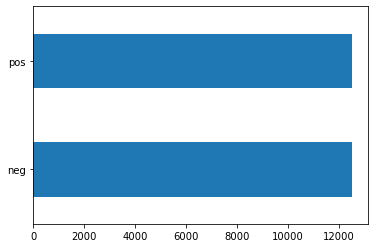

In [28]:
df_train["target"].value_counts().plot(kind='barh');

In [29]:
df_train["target"].value_counts()

neg    12500
pos    12500
Name: target, dtype: int64

In [30]:
df_train["value"].isna().sum()

0

Número de classes é igual e não parece ter valores faltantes

In [31]:
for i, value in enumerate(df_train["value"].head(10)):
    print(f"{i} - {value}")

0 - I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between,

Criação do dataset de teste e realizado alguns visualizações com os dados.

In [32]:
df_test = pd.DataFrame(test_data, columns=['target','value'])

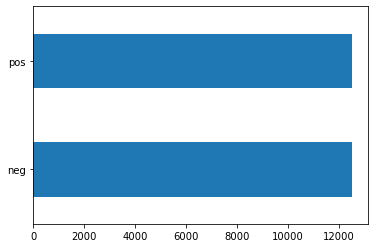

In [33]:
df_test["target"].value_counts().plot(kind='barh');

In [34]:
df_test["target"].value_counts()

neg    12500
pos    12500
Name: target, dtype: int64

In [35]:
df_test["value"].isna().sum()

0

In [37]:
for i, value in enumerate(df_test["value"].head(10)):
    print(f"{i} - {value}")

0 - I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it's rubbish as they have to a

## Processamento dos dados

Colocando todas as revisões em caixa baixa.

In [38]:
def apply_lower_case(df):
    df["value"] = df["value"].apply(lambda x: x.lower())

apply_lower_case(df_train)
apply_lower_case(df_test)

In [39]:
df_train.head(), df_test.head()

(  target                                              value
 0    neg  i rented i am curious-yellow from my video sto...
 1    neg  "i am curious: yellow" is a risible and preten...
 2    neg  if only to avoid making this type of film in t...
 3    neg  this film was probably inspired by godard's ma...
 4    neg  oh, brother...after hearing about this ridicul...,
   target                                              value
 0    neg  i love sci-fi and am willing to put up with a ...
 1    neg  worth the entertainment value of a rental, esp...
 2    neg  its a totally average film with a few semi-alr...
 3    neg  star rating: ***** saturday night **** friday ...
 4    neg  first off let me say, if you haven't enjoyed a...)

Remoção da pontuação

In [40]:
def apply_remove_punctuation(df):
    df["value"] = df["value"].apply(lambda x: ''.join([c for c in x if c not in punctuation]))
    
apply_remove_punctuation(df_train)
apply_remove_punctuation(df_test)
                                    
df_train.head(), df_test.head()

(  target                                              value
 0    neg  i rented i am curiousyellow from my video stor...
 1    neg  i am curious yellow is a risible and pretentio...
 2    neg  if only to avoid making this type of film in t...
 3    neg  this film was probably inspired by godards mas...
 4    neg  oh brotherafter hearing about this ridiculous ...,
   target                                              value
 0    neg  i love scifi and am willing to put up with a l...
 1    neg  worth the entertainment value of a rental espe...
 2    neg  its a totally average film with a few semialri...
 3    neg  star rating  saturday night  friday night  fri...
 4    neg  first off let me say if you havent enjoyed a v...)

## Tokenização

Criando o vocabulario com base no dataset de treino e o mapeamento de palavras para inteiros

In [41]:
all_text2 = ' '.join(df_train["value"].values)

# list de palavras
words = all_text2.split()
# Contagem das palavras
count_words = Counter(words)

total_words = len(words)
sorted_words = count_words.most_common(total_words)

In [42]:
print (count_words)

Counter({'the': 334691, 'and': 162228, 'a': 161940, 'of': 145326, 'to': 135042, 'is': 106855, 'in': 93028, 'it': 77099, 'i': 75719, 'this': 75190, 'that': 69352, 'br': 57143, 'was': 48008, 'as': 46662, 'for': 43964, 'with': 43871, 'movie': 41807, 'but': 41739, 'film': 37455, 'on': 33505, 'not': 30190, 'you': 29497, 'are': 29324, 'his': 29249, 'have': 27667, 'he': 26647, 'be': 26631, 'one': 25508, 'its': 25054, 'at': 23359, 'all': 23156, 'by': 22365, 'an': 21487, 'they': 20958, 'from': 20392, 'who': 20369, 'so': 19890, 'like': 19641, 'her': 18138, 'just': 17629, 'or': 17603, 'about': 17240, 'has': 16710, 'if': 16606, 'out': 16331, 'some': 15678, 'there': 15362, 'what': 15207, 'good': 14555, 'when': 14087, 'more': 14074, 'very': 13993, 'even': 12503, 'she': 12475, 'my': 12443, 'no': 12293, 'up': 12203, 'would': 12135, 'which': 11871, 'only': 11829, 'time': 11779, 'really': 11663, 'story': 11454, 'their': 11358, 'were': 11267, 'had': 11248, 'see': 11223, 'can': 11062, 'me': 10447, 'than':

O mapeamento de palavras para inteiros irá iniciar em 1 e não em 0. Essa mudança se deve ao uso de uma estratégia de padding que será aplicada as frases, onde o valor do padding será 0, então não queremos provocar sobreposição de valores. O padding será usado para deixar todas as frase com o mesmo tamanho, as vezes encurtando algumas, as vezes aumentanto outras. Para aumentar será incluido o valor 0 para fazer essa ocupação de espaço.

In [43]:
# adicionar +1 por conta do padding que será 0
vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

In [44]:
print (vocab_to_int)

{'the': 1, 'and': 2, 'a': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'it': 8, 'i': 9, 'this': 10, 'that': 11, 'br': 12, 'was': 13, 'as': 14, 'for': 15, 'with': 16, 'movie': 17, 'but': 18, 'film': 19, 'on': 20, 'not': 21, 'you': 22, 'are': 23, 'his': 24, 'have': 25, 'he': 26, 'be': 27, 'one': 28, 'its': 29, 'at': 30, 'all': 31, 'by': 32, 'an': 33, 'they': 34, 'from': 35, 'who': 36, 'so': 37, 'like': 38, 'her': 39, 'just': 40, 'or': 41, 'about': 42, 'has': 43, 'if': 44, 'out': 45, 'some': 46, 'there': 47, 'what': 48, 'good': 49, 'when': 50, 'more': 51, 'very': 52, 'even': 53, 'she': 54, 'my': 55, 'no': 56, 'up': 57, 'would': 58, 'which': 59, 'only': 60, 'time': 61, 'really': 62, 'story': 63, 'their': 64, 'were': 65, 'had': 66, 'see': 67, 'can': 68, 'me': 69, 'than': 70, 'we': 71, 'much': 72, 'well': 73, 'been': 74, 'get': 75, 'will': 76, 'into': 77, 'also': 78, 'because': 79, 'other': 80, 'do': 81, 'people': 82, 'bad': 83, 'great': 84, 'first': 85, 'how': 86, 'most': 87, 'him': 88, 'dont': 8

Fazer a codificação das palavras em números. Será só feito com o dataset de treino, pois o de testes será empregado uma estratégia diferente no final.

In [45]:
reviews_int = []
for review in df_train["value"].values:
    r = [vocab_to_int[w] for w in review.split()]
    reviews_int.append(r)
print (reviews_int[0:3])

[[9, 1533, 9, 236, 36644, 35, 55, 392, 1148, 79, 4, 31, 1, 7200, 11, 3309, 8, 50, 8, 13, 85, 625, 7, 7523, 9, 78, 543, 11, 30, 85, 8, 13, 20049, 32, 169, 9256, 44, 8, 121, 774, 5, 2461, 10, 714, 1561, 106, 3, 329, 4, 94, 1141, 3025, 9, 62, 66, 5, 67, 10, 15, 13603, 12, 1, 113, 6, 5949, 183, 3, 181, 3815, 475, 1473, 752, 4575, 36, 470, 5, 820, 278, 54, 68, 42, 118, 7, 816, 54, 470, 5, 1123, 39, 11996, 5, 244, 46, 424, 4, 668, 20, 48, 1, 862, 28812, 198, 42, 771, 985, 1301, 135, 14, 1, 2651, 332, 2, 1525, 1301, 7, 1, 2322, 1574, 7, 192, 2146, 6906, 2, 1887, 18993, 4, 21183, 42, 64, 4706, 20, 2396, 54, 43, 391, 16, 39, 475, 1719, 7988, 2, 1005, 9666, 12, 48, 1057, 69, 42, 9, 236, 36644, 6, 11, 1795, 147, 597, 10, 13, 1141, 8246, 62, 1, 391, 2, 1006, 136, 23, 162, 2, 233, 192, 53, 91, 29, 21, 318, 38, 46, 6606, 90, 4576, 130, 55, 24234, 347, 159, 8, 1575, 7, 638, 391, 2, 1006, 23, 3, 646, 10089, 7, 3815, 442, 53, 14623, 4941, 4577, 64, 1462, 5, 49, 164, 443, 297, 2018, 66, 391, 136, 7, 24,

Codificação dos labels, 1 para review positiva, 0 para uma negativa.

In [46]:
encoded_labels = [1 if label == 'pos' else 0 for label in df_train["target"]]
encoded_labels = np.array(encoded_labels)

encoded_labels

array([0, 0, 0, ..., 1, 1, 1])

## Análise dos dados codificados

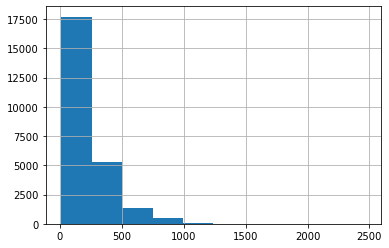

count    25000.000000
mean       232.872560
std        173.069452
min         10.000000
25%        127.000000
50%        174.000000
75%        283.000000
max       2469.000000
dtype: float64

In [47]:
reviews_len = [len(x) for x in reviews_int]
pd.Series(reviews_len).hist()
plt.show()
pd.Series(reviews_len).describe()

Olhando o histograma e a descrição dos dados é possível ver que a maioria das reviews não passam de 283 palavras, e temos algumas que são bem pequenas. 

In [48]:
# medida de segurança para a remoção de reviews que não possuem valor
reviews_int = [reviews_int[i] for i, l in enumerate(reviews_len) if l>0 ]
encoded_labels = [ encoded_labels[i] for i, l in enumerate(reviews_len) if l> 0 ]

## Função de Padding/Truncagem

Função para incluir espaço ou remover palavras de um review, tudo depende do tamanho dela.

In [2]:
def pad_features(reviews_int, seq_length):
    ''' Retorna um np.array do review_ints, onde cada review pode ter um padding adicionado com 0s ou ser truncada, tudo com base no seq_length 
    '''
    features = np.zeros((len(reviews_int), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_int):
        review_len = len(review)
        
        if review_len <= seq_length:
            zeroes = list(np.zeros(seq_length-review_len))
            new = zeroes+review
        elif review_len > seq_length:
            new = review[0:seq_length]
        
        features[i,:] = np.array(new)
    
    return features

Aplicando o padding

In [50]:
# aplicando um padding/trucagem de 300, visto que a mioria das reviews não vão passar disso
features = pad_features(reviews_int, 300)

In [51]:
print (features[:10,:])

[[    0     0     0 ...     4     3   113]
 [    0     0     0 ...     4  4578  2346]
 [    0     0     0 ...  2991 36646    12]
 ...
 [   50     9    85 ...   594   238    70]
 [   36    23   127 ...    49  3008    18]
 [    0     0     0 ...    31     1   341]]


## Preparando os Dataset para treinamento e validação

In [52]:
X_train, X_valid, y_train, y_valid = train_test_split(features, encoded_labels, test_size=0.2, 
                                                      random_state=42, stratify=encoded_labels)

In [53]:
# Criando os datasets
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(np.array(y_train)))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(np.array(y_valid)))

# Criando os dataloaders
batch_size = 50
# aplicando o SHUFFLE, pois os dados estão sequenciados em primeiro um tipo depois outro
# drop_last=True para não termos problemas com o ultimo batch de tamanho diferente
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [54]:
# Obtendo um batch de treinamento
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()
print('Size dos inputs de exemplo: ', sample_x.size()) # batch_size, seq_length
print('Inputs de exemplo: \n', sample_x)
print()
print('Size dos labels de exemplo: ', sample_y.size()) # batch_size
print('Labels de exemplo: \n', sample_y)

Size dos inputs de exemplo:  torch.Size([50, 300])
Inputs de exemplo: 
 tensor([[   0,    0,    0,  ...,  583,    4,  408],
        [1482, 4982,   10,  ..., 1685, 2700,    4],
        [   0,    0,    0,  ...,   12,   45,    4],
        ...,
        [   0,    0,    0,  ...,    9,   40,  116],
        [ 856,  562,    5,  ...,   66,   69, 1450],
        [5594,   14,    3,  ...,    3,  922,  970]], dtype=torch.int32)

Size dos labels de exemplo:  torch.Size([50])
Labels de exemplo: 
 tensor([1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
        0, 0], dtype=torch.int32)


## Definição da Rede

In [3]:
class SentimentLSTM(nn.Module):

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        # Camadas de embedding e LSTM
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
        # Camada Linear e sigmoid
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        # Recuperar o tamanho do batch, que é a primeira informação do input
        batch_size = x.size(0)

        # aplicação do embedding e LSTM
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # empilhar a saida da LSTM (lstm_out deve conter a soma dos estados da LSTM)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # Aplicação de dropout e da camada linear
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # Aplicando a função Sigmoid
        sig_out = self.sig(out)
        
        # Reshape para o tamanho do batch vir primeiro
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # pegar os labels
        
        # retorno
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Inicialização do estado oculto '''
        # Criar tensores com tamanho n_layers x batch_size x hidden_dim,
        # e inicializados com zero, para a LSTM
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

Inicialização dos hiperparâmetros e do modelo

In [62]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(121365, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Treinando a Rede

In [59]:
# Verificando a possibilidade de usar cuda para acelerar o processo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [63]:
lr=0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


# Parâmetros de treino

epochs = 4 # depois de 4 épocas o valor de loss da validação não decresce mais muito

counter = 0
print_every = 100
clip=5 # clipping do gradiente

net.to(device)

net.train()
# treinar pelas épocas definidas
for e in range(epochs):
    # inicializar o estado oculto
    h = net.init_hidden(batch_size)

    # loop de batchs
    for inputs, labels in train_loader:
        counter += 1

        inputs, labels = inputs.to(device), labels.to(device)

        # Criar novas variáveis para o estado oculto para não fazer
        # backpropagation por toda a história de treino
        h = tuple([each.data.to(device) for each in h])

        # zerar os gradientes acumulados
        net.zero_grad()

        inputs = inputs.type(torch.LongTensor).to(device)
        output, h = net(inputs, h)

        # Calcular a loss e realizar o backpropagation
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` para ajudar a previnir o problema de explosão de gradiente nas LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # Imprimir o estado da loss
        if counter % print_every == 0:
            # Calcular a loss para o dataset de validação
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval() # colcoar a rede em modo de avaliação
            for inputs, labels in valid_loader:

                # Criar novas variáveis para o estado oculto para não fazer
                # backpropagation por toda a história de treino
                val_h = tuple([each.data.to(device) for each in val_h])

                
                inputs, labels = inputs.to(device), labels.to(device)

                inputs = inputs.type(torch.LongTensor).to(device)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train() # retornar a rede para modo de treinamento
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

Epoch: 1/4... Step: 100... Loss: 0.642392... Val Loss: 0.638905
Epoch: 1/4... Step: 200... Loss: 0.696213... Val Loss: 0.689993
Epoch: 1/4... Step: 300... Loss: 0.711501... Val Loss: 0.658955
Epoch: 1/4... Step: 400... Loss: 0.588896... Val Loss: 0.568973
Epoch: 2/4... Step: 500... Loss: 0.405513... Val Loss: 0.436882
Epoch: 2/4... Step: 600... Loss: 0.351141... Val Loss: 0.428526
Epoch: 2/4... Step: 700... Loss: 0.459723... Val Loss: 0.356725
Epoch: 2/4... Step: 800... Loss: 0.228705... Val Loss: 0.339684
Epoch: 3/4... Step: 900... Loss: 0.208540... Val Loss: 0.394268
Epoch: 3/4... Step: 1000... Loss: 0.384405... Val Loss: 0.406897
Epoch: 3/4... Step: 1100... Loss: 0.287034... Val Loss: 0.355022
Epoch: 3/4... Step: 1200... Loss: 0.124289... Val Loss: 0.355350
Epoch: 4/4... Step: 1300... Loss: 0.154518... Val Loss: 0.429375
Epoch: 4/4... Step: 1400... Loss: 0.117615... Val Loss: 0.404742
Epoch: 4/4... Step: 1500... Loss: 0.046437... Val Loss: 0.456989
Epoch: 4/4... Step: 1600... Loss: 

## Preparando para o teste da rede

In [64]:
reviews_int_test = []
encoded_labels_test = []
for index, row in df_test.iterrows():
    # aqui, caso a palavra não exista no vocabulário, vamos atribuir um 0
    # como se tivesse um espaço vazio no meio do texto, já que a rede desconhece a palavra
    r = [vocab_to_int[w] if w in vocab_to_int else 0 for w in row["value"].split()]
    reviews_int_test.append(r)
    encoded_labels_test.append(1 if row["target"] == 'pos' else 0)  

# aplicando um padding/trucagem de 300, visto que a mioria das reviews não vão passar disso
features_test = pad_features(reviews_int_test, 300)
print (features_test[:10,:])

# Criando o dataset e o dataloader, no mesmo esquema que para o treinamento/validação
test_data = TensorDataset(torch.from_numpy(np.array(features_test)), torch.from_numpy(np.array(encoded_labels_test)))
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

[[    0     0     0 ...    31   125   172]
 [    0     0     0 ...    49  5198   655]
 [    0     0     0 ...   330   521   495]
 ...
 [    0     0     0 ...   779    10    28]
 [    0     0     0 ...  1732     8   630]
 [    0     0     0 ... 16237    10    19]]


In [66]:
# Calcular a loss e acurácia da base de teste

test_losses = [] # registro da loss
num_correct = 0

# iniciando o estado oculto
h = net.init_hidden(batch_size)

net.eval()

for inputs, labels in test_loader:

    # Criar novas variáveis para o estado oculto para não fazer
    # backpropagation por toda a história de treino
    h = tuple([each.data.to(device) for each in h])

    inputs, labels = inputs.to(device), labels.to(device)

    inputs = inputs.type(torch.LongTensor).to(device)
    output, h = net(inputs, h)
    
    # Calcular a loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    
    # Converter a probabilidade para uma das classes do label (0, 1), usando arredondamento
    pred = torch.round(output.squeeze()) 
    
    # comparar as predições corretas
    correct_tensor = pred.eq(labels.float().view_as(pred))
    # colocar o tensor na cpu para fazer os calculos
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# Média de loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# Acurácia total do teste
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.473
Test accuracy: 0.836


## Salvar o modelo e o vocabulário

In [68]:
net.cpu()
torch.save(net.state_dict(), "prediction_IMDB.pth")

In [82]:
exDict = {"vocab": vocab_to_int}

with open("vocab.txt", "w") as file:
     file.write(json.dumps(exDict)) # use `json.loads` to do the reverse

## Definição para carregar o modelo, vocabulário e fazer um predict

Carregando o vocabulário:

In [4]:
with open("vocab.txt", "r") as file:
     vocab_from_file = json.loads(file.read())

In [5]:
vocab_to_int = vocab_from_file["vocab"]

In [6]:
print(vocab_to_int)

{'the': 1, 'and': 2, 'a': 3, 'of': 4, 'to': 5, 'is': 6, 'in': 7, 'it': 8, 'i': 9, 'this': 10, 'that': 11, 'br': 12, 'was': 13, 'as': 14, 'for': 15, 'with': 16, 'movie': 17, 'but': 18, 'film': 19, 'on': 20, 'not': 21, 'you': 22, 'are': 23, 'his': 24, 'have': 25, 'he': 26, 'be': 27, 'one': 28, 'its': 29, 'at': 30, 'all': 31, 'by': 32, 'an': 33, 'they': 34, 'from': 35, 'who': 36, 'so': 37, 'like': 38, 'her': 39, 'just': 40, 'or': 41, 'about': 42, 'has': 43, 'if': 44, 'out': 45, 'some': 46, 'there': 47, 'what': 48, 'good': 49, 'when': 50, 'more': 51, 'very': 52, 'even': 53, 'she': 54, 'my': 55, 'no': 56, 'up': 57, 'would': 58, 'which': 59, 'only': 60, 'time': 61, 'really': 62, 'story': 63, 'their': 64, 'were': 65, 'had': 66, 'see': 67, 'can': 68, 'me': 69, 'than': 70, 'we': 71, 'much': 72, 'well': 73, 'been': 74, 'get': 75, 'will': 76, 'into': 77, 'also': 78, 'because': 79, 'other': 80, 'do': 81, 'people': 82, 'bad': 83, 'great': 84, 'first': 85, 'how': 86, 'most': 87, 'him': 88, 'dont': 8

Carregar o modelo salvo. Excute a célula que define o modelo antes.

In [7]:
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2
net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)
print(net)

SentimentLSTM(
  (embedding): Embedding(121365, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [8]:
# Carregar o modelo salvo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.load_state_dict(torch.load("prediction_IMDB.pth", map_location=device))
net.eval()

SentimentLSTM(
  (embedding): Embedding(121365, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)

Métodos para auxiliar. Executar a célula de imports e a que define a função `pad_features`

In [9]:
def tokenize_review(test_review):
    test_review = test_review.lower() # caixa baixa
    # remoção da pontuação
    test_text = ''.join([c for c in test_review if c not in punctuation])
    
    test_words = test_text.split()

    # criação dos tokens, seguindo a mesma estratégia do exemplo
    test_ints = []
    test_ints.append([vocab_to_int[word] if word in vocab_to_int else 0 for word in test_words])

    return test_ints


def predict(net, test_review, sequence_length=300):
    
    net.eval()
    
    # transformar a review em tokens
    test_ints = tokenize_review(test_review)
    
    # padding/truncagem
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)
    
    # converter em tensor
    feature_tensor = torch.from_numpy(features)
    
    batch_size = feature_tensor.size(0)
    
    # inicializar o estado oculto
    h = net.init_hidden(batch_size)
    
    feature_tensor.to(device)
    
    # gerar a predição
    output, h = net(feature_tensor, h)
    
    # arredondar a predição para ficar igual as classes (0 or 1)
    pred = torch.round(output.squeeze()) 
    # printing output value, before rounding
    print('Valor da predição, antes de arredondar: {:.6f}'.format(output.item()))
    
    # print custom response
    if(pred.item()==1):
        print("Review Positiva")
    else:
        print("Review Negativa")

In [10]:
# Critica tirada do rotten tomatos (https://www.rottentomatoes.com/m/the_boss_baby_family_business), 
# com score 6/10, tecnicamente daria pra considerar positiva
# link para o texto completo: https://www.ign.com/articles/the-boss-baby-2-family-business-review
test_reviw = "The Boss Baby: Family Business delivers middle-road mirth, full of action and quasi-clever jokes, and featuring the fun voice additions of James Marsden, Jeff Goldblum, and Amy Sedaris. Marsden's Tim borders on being unlikable for long stretches as he's so overly concerned with being adored that he actually tricks his daughter into revealing her secrets to him while he's a young kid, but in the end, this is a decent follow-up that'll delightfully distract a family for 90 minutes."

predict(net, test_reviw, 300)

Valor da predição, antes de arredondar: 0.997991
Review Positiva


Referencias:

Este trabalho foi feito seguindo o tutorial deste link: https://towardsdatascience.com/sentiment-analysis-using-lstm-step-by-step-50d074f09948